# Introduction
We will use the expectation maximization algorithm to obtain the parameters for a mixture model. The true probability density function will be
$$
f(x) = \frac{0.6}{\sqrt{2\pi}}\exp\left[-\frac{x^2}{2}\right] + \frac{0.4}{\sqrt{2\pi}}\exp\left[-\frac{\left(x - 4\right)^2}{2}\right]
$$
for this exercise, *i.e.* the distribution is a mixutre of two normals. We will use $f$ to generate $x_1, x_2,\ldots, x_n$ and then use the expectionation maximization algorithm to obtain our parameter estimates. Notice that the standard deviation is identical (and equal to 1) for each of the two normal probability density functions. We will treat the following as known attributes: 
* the distribution of the data is a mixture two normal distributions, and
* the standard devaitions for the two distributions in the mixture are identical. 

This code was heavily influenced by R code from the UCSC Coursera course *Bayesian Statistics: Mixture Models*. Click [here](https://www.coursera.org/learn/mixture-models/supplement/H81ay/sample-code-for-em-example-1) for more details.


# Packages and Setup

In [76]:
# Import packages
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Enable LaTeX for plt graphs
plt.rcParams['text.usetex'] = True

In [77]:
# Set random seed
np.random.seed(0)

# Initialize variables
K = 2
w_true = np.array([0.6, 0.4])
mu_true = np.array([0, 4])
sigma_true = 1
n = 100

# Randomly generate c_i values given probabilities w_true
c = np.random.choice(range(K), n, replace = True, p = w_true)

# Use c to generate data
x = np.array([stats.norm.rvs(loc = mu_true[c_i], scale = sigma_true, size = 1)[0] for c_i in c])    

Let us examine the true density function.

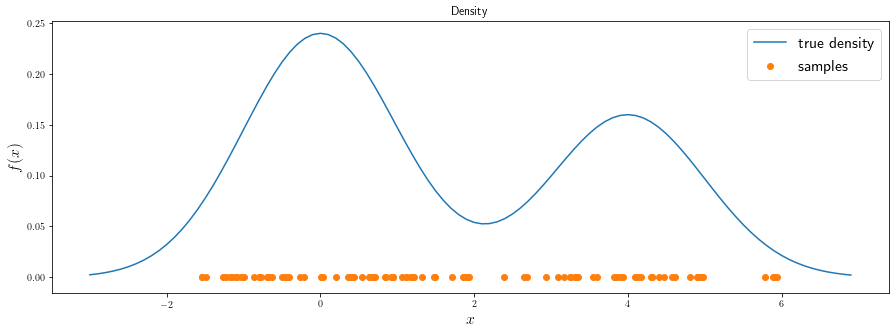

In [78]:
# Define an array of x-values to be used for graphs
x_arr = np.arange(-3, 7, 0.10)

# Calculate true y-values of density function evaluated on x_arr
y_true = (w_true[0] * stats.norm.pdf(x_arr, loc = mu_true[0], scale = sigma_true) 
           + w_true[1] * stats.norm.pdf(x_arr, loc = mu_true[1], scale = sigma_true))

# Save array of default colors
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Plot the true density graph and the samples
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(x_arr, y_true, label = 'true density')
ax.scatter(x, np.zeros(n), color = colors[1], label = 'samples')
ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()

We will initialize our values for the expectation maximization algorithm. The intialization for $\sigma$ is $std(x_i)$ and the intialization of $\mu$ is $(\bar{x_i} - std(x_i), \bar{x_i} + std(x_i))$. 

The graph of the density function we initialized is plotted below. As can be seen, the initial distribution only has one mode unlike the bimodal true distribution. This is most likely because $\sigma$ for the true distribution is much smaller than the value in which it was initialized.

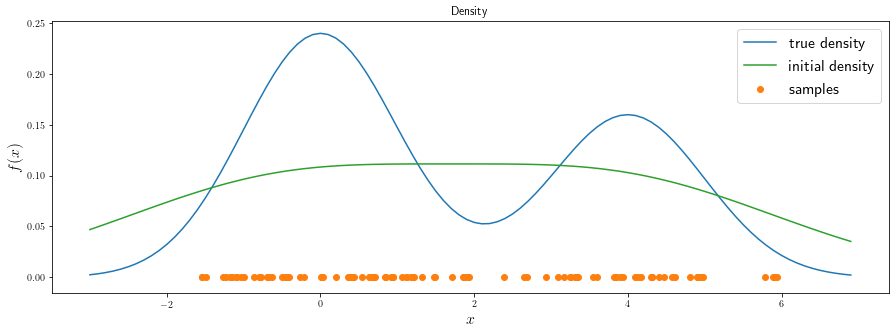

In [79]:
# Initialize values for algorithm 
w = np.array([0.5, 0.5])
sigma = np.std(x)
mu = np.array([np.mean(x) - sigma, np.mean(x) + sigma])
s = 0
sw = False
Q = -np.Inf
Q_out = None
epsilon = 10**-6

# Calculate y-values of pdf for graph
y_est = w[0] * stats.norm.pdf(x_arr, mu[0], sigma) + w[1] * stats.norm.pdf(x_arr, mu[1], sigma)

# Plot the initial estimate
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(x_arr, y_true, color = colors[0], label = 'true density')
ax.plot(x_arr, y_est, color = colors[2], label = 'initial density')
ax.scatter(x, np.zeros(n), color = colors[1], label = 'samples')
ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()

The expectionation maximization algorithm is written below.

In [80]:
# Run algorithm
while sw == False:
    
    # Initialize v
    v = np.reshape(np.zeros(n * K), (n, K))
    
    # Calculate values for v in this iteration 
    v[: , 0] = np.log(w[0]) + stats.norm.logpdf(x, loc = mu[0], scale = sigma)
    v[: , 1] = np.log(w[1]) + stats.norm.logpdf(x, loc = mu[1], scale = sigma)
    
    for i in range(n):
        
        # Convert v-values to maintain numerical stability
        v[i, :] = np.exp(v[i , :] - np.max(v[i , :]))/np.sum(np.exp(v[i , :] - np.max(v[i , :])))
    
    # Take the average of each column to obtain weights
    w = np.mean(v, axis = 0)
    
    # Initialize mu
    mu = np.zeros(K)
    
    for k in range(K):
        
        mu[k] = np.sum(v[:, k] * x)/np.sum(v[:, k])
        
    sigma = 0
    
    for k in range(K):
            
            sigma += np.sum(v[:, k] * (x - mu[k])**2)
            
    sigma = np.sqrt(sigma/np.sum(v))
        
    Qn = np.sum(v[:, 0] * (np.log(w[0]) + stats.norm.logpdf(x, loc = mu[0], scale = sigma)) 
                + v[:, 1] * (np.log(w[1]) + stats.norm.logpdf(x, loc = mu[1], scale = sigma)))
    
    if np.abs(1 - Q/Qn) < epsilon:
        
        sw = True
           
    Q = Qn
    
    Q_out = np.append(Q_out, Q)
    
    s += 1


# Results

We will first plot $Q$ as a function $n$. It shows that we quickly converged to the parameter estimates. After about the 7th iteration, the graph becomes almost flat.

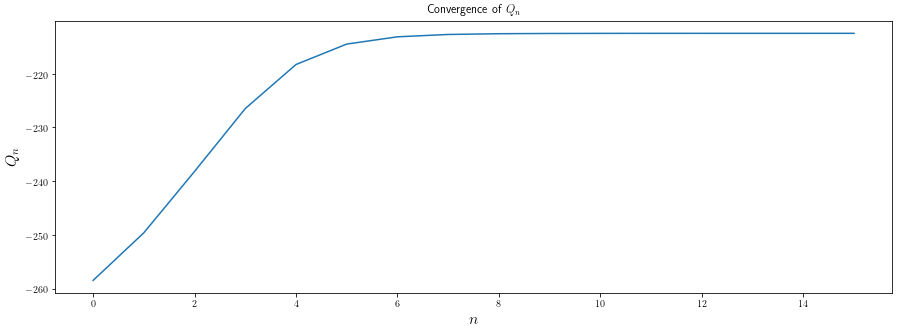

In [81]:
# The first Q_out was None so remove it
Q_out = Q_out[1:]

# Plot progress of Q each iteration
fig, ax = plt.subplots(figsize = (15, 5))

ax.plot(range(len(Q_out)), Q_out)
ax.set_xlabel(r'$n$', fontsize = 16)
ax.set_ylabel(r'$Q_n$', fontsize = 16)
ax.set_title(r'Convergence of $Q_n$')

plt.show()

Lastly, we will examine the graph of our estimated pdf and the true pdf. As can be seen, the estimated density is close to the true one. Our conclusions are strong, especially given that we only used 100 points.

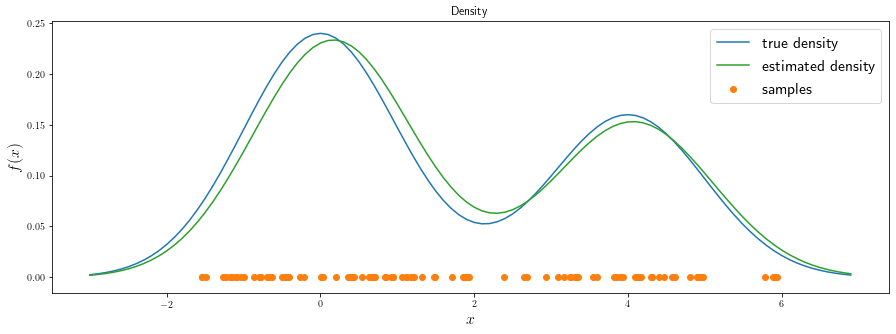

In [82]:
# Calculate y-values of final estimate of density
y_est = w[0] * stats.norm.pdf(x_arr, mu[0], sigma) + w[1] * stats.norm.pdf(x_arr, mu[1], sigma)

# Plot final estimate of density
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(x_arr, y_true, color = colors[0], label = 'true density')
ax.plot(x_arr, y_est, color = colors[2], label = 'estimated density')
ax.scatter(x, np.zeros(n), color = colors[1], label = 'samples')
ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()